In [1]:
import torchvision.transforms
import source.data
import source.utils
import math
import torch.hub
import torch.utils.data
import torch
import torch.optim
import source.modules
import source.constants
import torchvision.models.segmentation
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
_  = torch.manual_seed(0)

cpu_device = torch.device('cpu')
device = torch.device('cuda:0')

torch.cuda.empty_cache()

In [3]:



image_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(lambda image_as_int_tensor: image_as_int_tensor / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((336, 448)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(
        lambda mask_as_int_tensor: mask_as_int_tensor.squeeze().type(torch.LongTensor)
    ),
])

dataset = source.data.AugmentedPascalPartDataset(
    transform=image_transform,
    target_transform=mask_transform
)

dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=6)

weights = torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT
model = torchvision.models.segmentation.fcn_resnet101(weights=weights, progress=False)

classifier = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
    torch.nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1, inplace=False),
    torch.nn.Conv2d(512, 7, kernel_size=(1, 1), stride=(1, 1))
)

model.classifier = classifier
model.aux_classifier = torch.nn.Identity()

checkpoint = torch.load(f"{source.constants.REPOSITORY_ROOT}/checkpoints/resnet101.pth")
model.load_state_dict(checkpoint)
_ = model.to(device)

/tmp/ipykernel_141050/922050957.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{source.constants.REPOSITORY_ROOT}/checkpoints/resnet101.pth")

KeyError: 'model'

In [6]:
evaluation_dataset = source.data.PascalPartDataset(
    transform=image_transform,
    train=False,
)
_ = model.eval()
evaluation_metrics_tracker = {index:[] for index in range(0, 10)}

In [7]:
with torch.no_grad():
    for image, mask in evaluation_dataset:
        image = image.to(device)
        mask = mask.to(device)
        
        mask_shape = mask.shape
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output_logits = model(image)['out']

        log_probabilities = torch.nn.functional.log_softmax(
            output_logits,
            dim=1, # 1 x C x H x W
        )

        upsampled_log_probabilities = torch.nn.functional.interpolate(
            input=log_probabilities,
            size=mask_shape,
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=upsampled_log_probabilities,
            masks=mask,
            classes=list(dataset.class_to_name.keys()),
        )

        for object_class in range(0, 10):
            filtered_iou = intersection_over_union_per_class[object_class][
                intersection_over_union_per_class[object_class] >= 0.
            ].to(cpu_device).detach()
            if filtered_iou.numel():
                evaluation_metrics_tracker[object_class].append(filtered_iou.mean().item())

print(
    "IoU - ",
    *[
        f"{evaluation_dataset.class_to_name[object_class]} : " +
        f"{sum(evaluation_metrics_tracker[object_class]) / len(evaluation_metrics_tracker[object_class]):.3f} \t "
        for object_class in list(evaluation_dataset.class_to_name.keys())
    ],
    f"upper_body: {sum(evaluation_metrics_tracker[7]) / len(evaluation_metrics_tracker[7]):.3f} \t ",
    f"lower_body: {sum(evaluation_metrics_tracker[8]) / len(evaluation_metrics_tracker[8]):.3f} \t ",
    f"body: {sum(evaluation_metrics_tracker[9]) / len(evaluation_metrics_tracker[9]):.3f} \t ",
)

IoU -  bg : 0.941 	  low_hand : 0.418 	  torso : 0.591 	  low_leg : 0.358 	  head : 0.717 	  up_leg : 0.403 	  up_hand : 0.469 	  upper_body: 0.319 	  lower_body: 0.447 	  body: 0.734 	 


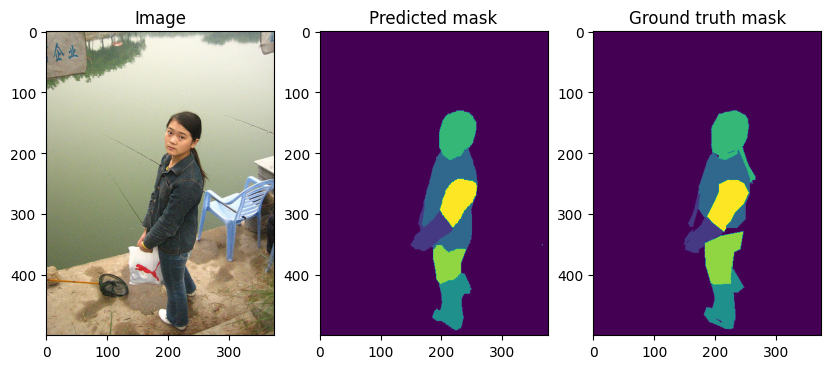

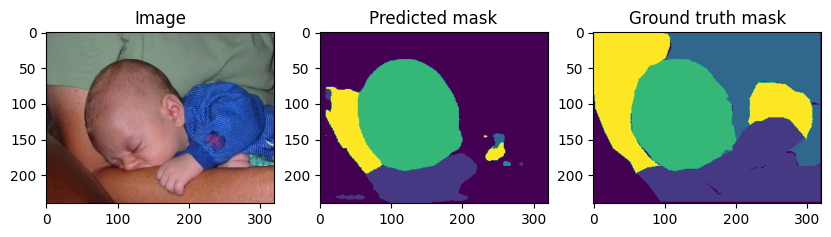

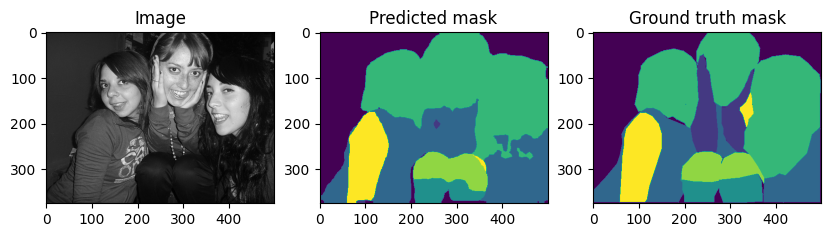

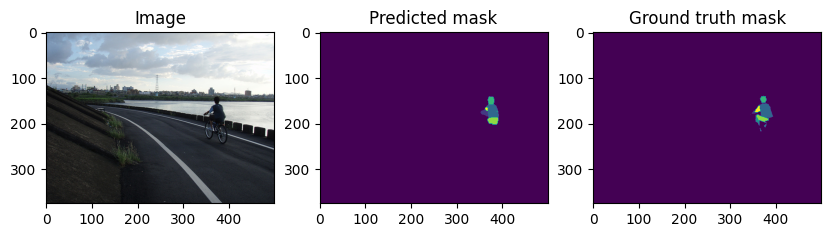

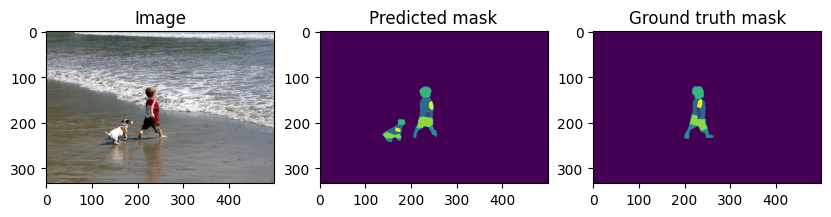

In [8]:
for _ in range(5):
    random_index = torch.randint(0, len(evaluation_dataset), size=(1, )).item()
    original_image, original_mask = source.data.PascalPartDataset(train=False)[random_index]
    mask_shape = original_mask.shape
    image = image_transform(original_image).unsqueeze(0)
    mask = mask.unsqueeze(0)

    image = image.to(device)
    output_logits = model(image)['out']


    log_probabilities = torch.nn.functional.log_softmax(
        output_logits,
        dim=1, # 1 x C x H x W
    )
    upsampled_log_probabilities = torch.nn.functional.interpolate(
        input=log_probabilities,
        size=mask_shape,
    )
    predicted_mask = upsampled_log_probabilities.argmax(
        dim=1
    ).squeeze().to(cpu_device)

    figure = plt.figure(figsize=(10, 4))

    figure.add_subplot(1, 3, 1)
    plt.imshow(original_image.squeeze().permute(1, 2, 0))
    plt.title("Image")

    figure.add_subplot(1, 3, 2)
    plt.imshow(predicted_mask)
    plt.title("Predicted mask")

    figure.add_subplot(1, 3, 3)
    plt.imshow(original_mask.squeeze())
    plt.title("Ground truth mask")

    plt.show()

In [9]:
from source.constants import REPOSITORY_ROOT
torch.save(
    {
        "model": model.state_dict(),
        "evaluation_loss": evaluation_metrics_tracker,
    },
    f"{REPOSITORY_ROOT}/checkpoints/augmented_resnet101_schedule_10000_resize_336_448.pth"
)